In [1]:
%matplotlib inline

import os

import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from botorch.models.gpytorch import GPyTorchModel
from botorch.fit import fit_gpytorch_model
from botorch.utils.transforms import standardize, normalize, unnormalize
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, ProbabilityOfImprovement
from scipy import linalg
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import PathToSubmol, FindAtomEnvironmentOfRadiusN, MolToSmiles
from rdkit.Chem.AtomPairs import Pairs
from MDAnalysis.analysis.rms import rmsd
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from map4 import MAP4Calculator
import tmap as tm


from mobius import ForceField, VirtualTarget

In [493]:
temperature = 300.
RT = 0.001987 * temperature
RT * np.log(4 * 1e-9)

-11.526768696740188

## Load dataset

In [2]:
mhci = pd.read_csv('binding_data_2013/bdata.20130222.mhci.csv')

In [3]:
# We removed those binding affinity values
# A lot of peptides were set with those values. Looks like some default values assigned...
dirty_values = [1, 2, 3, 5000, 10000, 20000, 43424, 50000, 69444.44444, 78125]

# Split dataset in training and testing sets
mhci = mhci[(mhci['mhc_allele'] == 'HLA-A*02:01') &
                (~mhci['affinity_binding'].isin(dirty_values))]

In [479]:
class TanimotoSimilarityKernel(gpytorch.kernels.Kernel):
    # the sequence kernel is stationary
    is_stationary = True     

    # this is the kernel function
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        if last_dim_is_batch:
            # Not tested
            x1 = x1.transpose(-1, -2).unsqueeze(-1)
            x2 = x2.transpose(-1, -2).unsqueeze(-1)

        x1_eq_x2 = torch.equal(x1, x2)
        
        x1s = torch.sum(torch.square(x1), dim=-1)
        x2s = torch.sum(torch.square(x2), dim=-1)
        
        if diag:
            if x1_eq_x2:
                res = torch.ones(*x1.shape[:-2], x1.shape[-2], dtype=x1.dtype, device=x1.device)
                return res
            else:
                product = torch.mul(x1, x2).sum(dim=1)
                denominator = torch.add(x2s, x1s) - product
        else:
            product = torch.mm(x1, x2.transpose(1, 0))
            denominator = torch.add(x2s, x1s[:, None]) - product

        res = product / denominator
        
        return res

    
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP, GPyTorchModel):
    # to inform GPyTorchModel API
    _num_outputs = 1
    
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(TanimotoSimilarityKernel())
        # make sure we're on the right device/dtype
        self.to(train_x)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    
def get_fitted_model(train_x, train_y, state_dict=None):
    # initialize and fit model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)
    
    if state_dict is not None:
        model.load_state_dict(state_dict)
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    mll.to(train_x)
    
    # Train model!
    fit_gpytorch_model(mll)
    
    return model

In [480]:
def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))


def plot(y_test, observed_pred, fig_filename=None):
    with torch.no_grad():
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        ax.scatter(y_test, observed_pred)
        
        ax.set_xlim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_ylim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_xlabel('Experimental values (kcal/mol)', fontsize=20)
        ax.set_ylabel('Predicted values (kcal/mol)', fontsize=20)
        
        if fig_filename is not None:
            plt.savefig(fig_filename, bbox_inches='tight', dpi=300)
        
        plt.show()

In [481]:
def map4_fingerprint(sequences, dimensions=4096, radius=2, is_folded=True):
    MAP4_unf = MAP4Calculator(dimensions=dimensions, radius=radius, is_folded=is_folded)
    fps = MAP4_unf.calculate_many([Chem.rdmolfiles.MolFromFASTA(s) for s in sequences])
    return torch.from_numpy(np.array(fps)).float()

## Random train-test (70/30) split (ALL SIZE PEPTIDE)

In [482]:
X_train, X_test, y_train, y_test = train_test_split(mhci['sequence'], mhci['energy'], test_size=0.3)

print(X_train.shape, X_test.shape)

X_train_fps = map4_fingerprint(X_train)
X_test_fps = map4_fingerprint(X_test)

y_train = torch.from_numpy(y_train.values).float()
y_test = torch.from_numpy(y_test.values).float()

(5956,) (2553,)


In [483]:
model = get_fitted_model(X_train_fps, y_train)

R2   : 0.599
RMSD : 1.223 kcal/mol


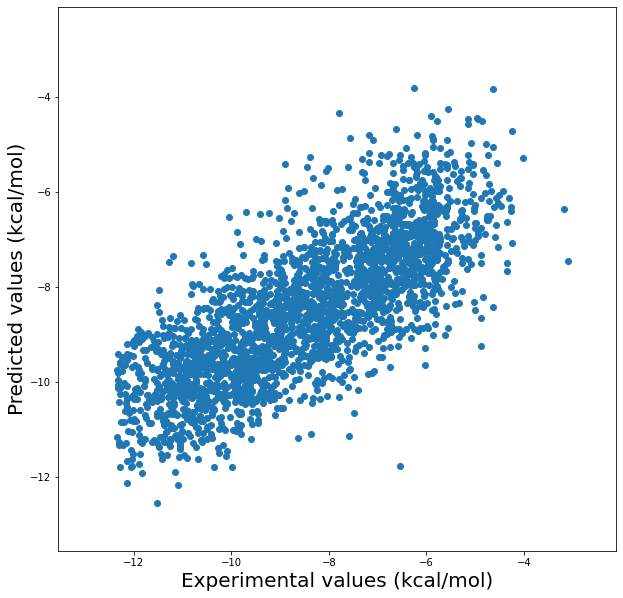

In [485]:
# Predict energy for test set
observed_pred = predict(model, model.likelihood, X_test_fps)
 
print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename='correlation_exp_pred_MAP4_fps_tanimoto_mhc-i_cleaned_all_size_pep.png')

## Bayesian opt. prototype

In [604]:
def expected_improvement(model, Y_train, Xsamples, greater_is_better=False):
    """ expected_improvement
    Expected improvement acquisition function.
    
    Source: https://github.com/thuijskens/bayesian-optimization/blob/master/python/gp.py
    
    Arguments:
    ----------
        model: Gaussian process model
        Y_train: Array that contains all the observed energy interaction seed so far
        X_samples: Samples we want to try out
        greater_is_better: Indicates whether the loss function is to be maximised or minimised.

    """
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()

    if greater_is_better:
        loss_optimum = np.max(Y_train.numpy())
    else:
        loss_optimum = np.min(Y_train.numpy())

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + (sigma * norm.pdf(Z))
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement


# probability of improvement acquisition function
def probability_of_improvement(model, Y_train, Xsamples, greater_is_better=False):
    """ probability_of_improvement
    Probability of improvement acquisition function.
        
    Arguments:
    ----------
        model: Gaussian process model
        Y_train: Array that contains all the observed energy interaction seed so far
        X_samples: Samples we want to try out
        greater_is_better: Indicates whether the loss function is to be maximised or minimised.

    """
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()
    
    if greater_is_better:
        loss_optimum = np.max(Y_train.numpy())
    else:
        loss_optimum = np.min(Y_train.numpy())

    scaling_factor = (-1) ** (not greater_is_better)
    
    # calculate the probability of improvement
    Z = scaling_factor * (mu - loss_optimum) / (sigma + 1E-9)
    probs = norm.cdf(Z)
    probs[sigma == 0.0] == 0.0
    
    return probs

In [564]:
# Compute the MAP4 fingerprint for all the peptides
X_fps = map4_fingerprint(mhci['sequence'].values)
y = torch.from_numpy(mhci['energy'].values).float()

In [611]:
# Select n_training (here 150) low affinity binding peptides (energy > -8.5) for the initial training set
# The other peptides will constitute the peptides pool fro, where we will draw the candidates during the otimization

energy_cutoff = -8.5
n_training = 150

low_affinity_ids = np.where(y.numpy() >= energy_cutoff)[0]
high_affinity_ids = np.where(y.numpy() < energy_cutoff)[0]

print('Low affinity : %d' % low_affinity_ids.shape[0])
print('High affinity: %d' % high_affinity_ids.shape[0])

train_ids = np.random.choice(low_affinity_ids, size=n_training, replace=False)
low_affinity_ids_leftover = low_affinity_ids[~np.in1d(low_affinity_ids, train_ids)]

X_train_fps, y_train = X_fps[train_ids], y[train_ids]
X_pool_fps = torch.cat([X_fps[high_affinity_ids], X_fps[low_affinity_ids_leftover]])
y_pool = torch.cat([y[high_affinity_ids], y[low_affinity_ids_leftover]])

print('Train: %4d - %.3f %%' % (X_train_fps.shape[0], X_train_fps.shape[0] / mhci.shape[0]* 100.))
print('Pool : %4d - %.3f %%' % (X_pool_fps.shape[0], X_pool_fps.shape[0] / mhci.shape[0]* 100.))

Low affinity : 4361
High affinity: 4148
Train:  150 - 1.763 %
Pool : 8359 - 98.237 %


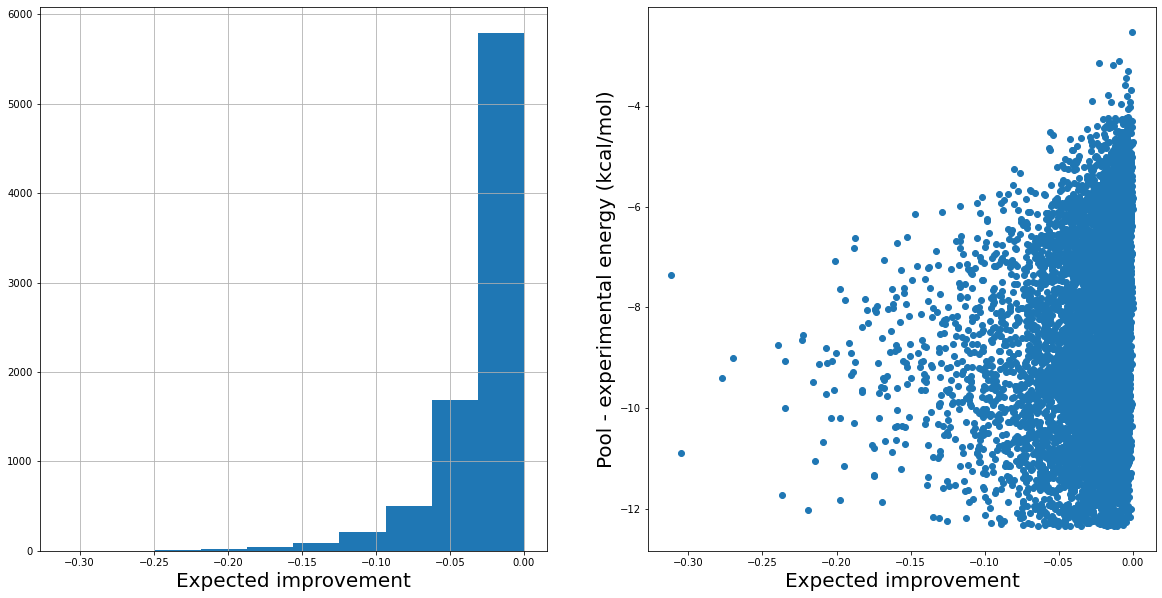

In [613]:
# Show the Expected improvement for the initial model

model = get_fitted_model(X_train_fps, y_train)

fig, axarr = plt.subplots(1, 2, figsize=(20, 10))

p = expected_improvement(model, y_train, X_pool_fps)

pd.Series(p).hist(ax=axarr[0])
axarr[0].set_xlabel('Expected improvement', fontsize=20)

axarr[1].scatter(p, y_pool)
axarr[1].set_xlabel('Expected improvement', fontsize=20)
axarr[1].set_ylabel('Pool - experimental energy (kcal/mol)', fontsize=20)
plt.show()

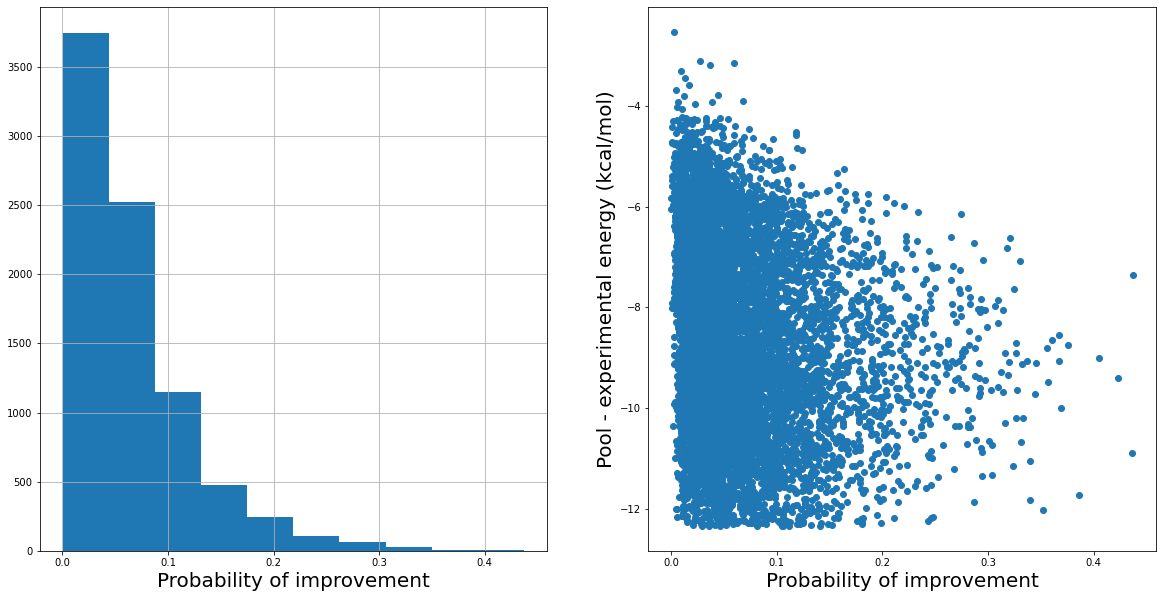

In [618]:
# Show the Probability of improvement for the initial model

model = get_fitted_model(X_train_fps, y_train)

fig, axarr = plt.subplots(1, 2, figsize=(20, 10))

p = probability_of_improvement(model, y_train, X_pool_fps)

pd.Series(p).hist(ax=axarr[0])
axarr[0].set_xlabel('Probability of improvement', fontsize=20)

axarr[1].scatter(p, y_pool)
axarr[1].set_xlabel('Probability of improvement', fontsize=20)
axarr[1].set_ylabel('Pool - experimental energy (kcal/mol)', fontsize=20)
plt.show()

In [616]:
cX_train_fps = X_train_fps.clone()
cy_train = y_train.clone()
cX_pool_fps = X_pool_fps.clone()
cy_pool = y_pool.clone()

n_pep = 96
acq_function = 'PI'

print('Init.')
print('Train: ', cX_train_fps.shape[0])
print('Pool : ', cX_pool_fps.shape[0])
print('Best peptide: %.3f' % cy_train.min())
for n in [-12, -11, -10, -9]:
    print('N pep under %d kcal/mol: %03d' % (n, cy_train[cy_train < n].shape[0]))
    
print()

for i in range(3):
    print(i + 1)
    model = get_fitted_model(cX_train_fps, cy_train)
    
    if acq_function == 'EI':
        p = expected_improvement(model, cy_train, cX_pool_fps)
        indices = np.argsort(p)
    else:
        p = probability_of_improvement(model, cy_train, cX_pool_fps)
        indices = np.argsort(p)[::-1]
    
    # Add new data to train dataset
    cX_train_fps = torch.cat([cX_train_fps, torch.from_numpy(cX_pool_fps.numpy()[indices[:n_pep]]).float()])
    cy_train = torch.cat([cy_train, torch.from_numpy(cy_pool.numpy()[indices[:n_pep]]).float()])
    print('Train: ', cX_train_fps.shape[0])
    
    # Remove peptides from pool
    cX_pool_fps = cX_pool_fps[n_pep:]
    cy_pool = cy_pool[n_pep:]
    print('Pool : ', cX_pool_fps.shape[0])
    print('Best peptide: %.3f' % cy_train.min())
    
    for n in [-12, -11, -10, -9]:
        x = cy_train[cy_train < n].shape[0]
        print('N pep under %d kcal/mol: %03d (%.3f)' % (n, x, x / (n_pep * (i + 1)) * 100.))
    
    print()

Init.
Train:  150
Pool :  8359
Best peptide: -8.496
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000

1
Train:  246
Pool :  8263
Best peptide: -12.023
N pep under -12 kcal/mol: 001 (1.042)
N pep under -11 kcal/mol: 008 (8.333)
N pep under -10 kcal/mol: 027 (28.125)
N pep under -9 kcal/mol: 054 (56.250)

2
Train:  342
Pool :  8167
Best peptide: -12.303
N pep under -12 kcal/mol: 005 (2.604)
N pep under -11 kcal/mol: 031 (16.146)
N pep under -10 kcal/mol: 077 (40.104)
N pep under -9 kcal/mol: 136 (70.833)

3
Train:  438
Pool :  8071
Best peptide: -12.303
N pep under -12 kcal/mol: 007 (2.431)
N pep under -11 kcal/mol: 057 (19.792)
N pep under -10 kcal/mol: 133 (46.181)
N pep under -9 kcal/mol: 213 (73.958)



R2   : 0.278
RMSD : 1.666 kcal/mol


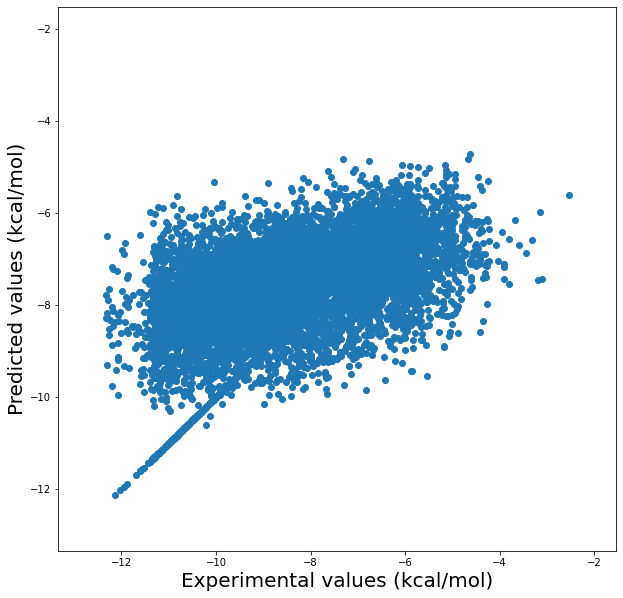

In [558]:
# Predict energy for test set
observed_pred = predict(model, model.likelihood, cX_pool_fps)
 
print('R2   : %.3f' % pearsonr(cy_pool, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(cy_pool, observed_pred.mean.numpy()))

# Plot results
plot(cy_pool.numpy(), observed_pred.mean.numpy(), fig_filename=None)